In [2]:
import backtrader as bt
from backtrader import num2date
# from utils import *
import pandas as pd
from TradingUtils.dataflow import FuturesCSVData, FuturesPandasData 
from pathlib import Path

cerebro = bt.Cerebro()
cols = ['pre_close', 'open', 'high', 'low', 'close', 'volume', 'amount', 'vwap', 'pre_settle', 'settle', 'openinterest']
lt = []
for x in Path('./input/quote/').glob('*.csv'):
    df = pd.read_csv(x, index_col=0)
    df.index = pd.to_datetime(df.index)
    df.columns = cols
    df['sec_code'] = x.stem
    lt.append(df)
daily_info = pd.concat(lt, axis=0)
date_list = daily_info.index.unique().sort_values()

for code in daily_info['sec_code'].unique():
    temp_df = pd.DataFrame(index=date_list)
    df = daily_info.query(f" sec_code == '{code}' ")[cols]
    df = pd.merge(temp_df, df, left_index=True, right_index=True, how='left')
    cerebro.adddata(FuturesPandasData(dataname=df), name=code)

# for x in Path('./input/quote/').glob('*.csv'):
#     # TODO: date is not padding, bt.Strategy.__next__ will have bug
#     cerebro.adddata(FuturesCSVData(dataname=str(x)), name=x.stem)


# class TestStrategy(bt.Strategy):
#     def __init__(self):
#         self.count = 0  # 用于计算 next 的循环次数
#         # 打印数据集和数据集对应的名称
#         print("------------- init 中的索引位置-------------")
#         print(self.datas[0].lines.getlinealiases())
#         print("0 索引：", 'datetime', self.data.lines.datetime.date(0), 'close', self.data.lines.close[0])
#         print("-1 索引：", 'datetime', self.data.lines.datetime.date(-1), 'close', self.data.lines.close[-1])
#         print("-2 索引", 'datetime', self.data.lines.datetime.date(-2), 'close', self.data.lines.close[-2])
#         print("1 索引：", 'datetime', self.data.lines.datetime.date(1), 'close', self.data.lines.close[1])
#         print("2 索引", 'datetime', self.data.lines.datetime.date(2), 'close', self.data.lines.close[2])
#         print("从 0 开始往前取3天的收盘价：", self.data.lines.close.get(ago=0, size=3))
#         print("从-1开始往前取3天的收盘价：", self.data.lines.close.get(ago=-1, size=3))
#         print("从-2开始往前取3天的收盘价：", self.data.lines.close.get(ago=-2, size=3))
#         print("line的总长度：", self.data.buflen())

#     def next(self):
#         print(f"------------- next 的第{self.count + 1}次循环 --------------")
#         print("当前时点（今日）：", 'datetime', self.data.lines.datetime.date(0), 'close', self.data.lines.close[0])
#         print("往前推1天（昨日）：", 'datetime', self.data.lines.datetime.date(-1), 'close', self.data.lines.close[-1])
#         print("往前推2天（前日）", 'datetime', self.data.lines.datetime.date(-2), 'close', self.data.lines.close[-2])
#         # print("前日、昨日、今日的收盘价：", self.data.lines.close.get(ago=0, size=3))
#         # print("往后推1天（明日）：", 'datetime', self.data.lines.datetime.date(1), 'close', self.data.lines.close[1])
#         # print("往后推2天（明后日）", 'datetime', self.data.lines.datetime.date(2), 'close', self.data.lines.close[2])
#         print("已处理的数据点：", len(self.data))
#         print("line的总长度：", self.data0.buflen())
#         self.count += 1

class FuturesRollingStrategy(bt.Strategy):

    def __init__(self):
        # 读取调仓表，表结构如下所示：
        # trade_date sec_code weight
        # 0 2019-01-31 000006.SZ 0.007282
        # 1 2019-01-31 000008.SZ 0.009783
        # ... ... ... ...
        # 2494 2021-01-28 688088.SH 0.007600
        self.buy_assets = pd.read_csv("./input/signal/trade_info.csv", parse_dates=['trade_date'])
        # 读取调仓日期，即每月的最后一个交易日，回测时，会在这一天下单，然后在下一个交易日，以开盘价买入
        self.trade_dates = pd.to_datetime(self.buy_assets['trade_date'].unique()).tolist()
        self.order_list = []  # 记录以往订单，方便调仓日对未完成订单做处理
        self.buy_assets_pre = []  # 记录上一期持仓

    def log(self, txt, dt=None):
        ''' 策略日志打印函数'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def next(self):
        dt = self.datas[0].datetime.date(0)  # 获取当前的回测时间点
        # 如果是调仓日，则进行调仓操作
        if dt in self.trade_dates:
            print("--------------{} 为调仓日----------".format(dt))
            # 在调仓之前，取消之前所下的没成交也未到期的订单
            if len(self.order_list) > 0:
                for od in self.order_list:
                    self.cancel(od)  # 如果订单未完成，则撤销订单
                self.order_list = []  # 重置订单列表
            # 提取当前调仓日的持仓列表
            buy_assets_data = self.buy_assets.query(f"trade_date=='{dt}'")
            long_assets = buy_assets_data['sec_code'].tolist()
            print('long assets', long_assets)  # 打印持仓列表
            # 对现有持仓中，调仓后不再继续持有的股票进行卖出平仓
            sell_assets = [i for i in self.buy_assets_pre if i not in long_assets]
            print('sell_assets', sell_assets)  # 打印平仓列表
            if len(sell_assets) > 0:
                print("-----------对不再持有的股票进行平仓--------------")
                for asset in sell_assets:
                    data = self.getdatabyname(asset)
                    if self.getposition(data).size > 0:
                        od = self.close(data=data)
                        self.order_list.append(od)  # 记录卖出订单
            # 买入此次调仓的股票：多退少补原则
            print("-----------买入此次调仓期的股票--------------")
            for asset in long_assets:
                w = buy_assets_data.query(f"sec_code=='{asset}'")['weight'].iloc[0]  # 提取持仓权重
                data = self.getdatabyname(asset)
                order = self.order_target_percent(data=data, target=w * 0.9)  # 为减少可用资金不足的情况，留 5% 的现金做备
                # if asset == 'T1612.CFE':
                #     import pdb
                #     pdb.set_trace()
                # if asset == 'T1703.CFE':
                #     import pdb
                #     pdb.set_trace()
                self.order_list.append(order)
                

            self.buy_assets_pre = long_assets  # 保存此次调仓的股票列表
            

            hold_bond_name = [_p._name for _p in self.broker.positions if self.broker.getposition(_p).size > 0]
            open_positions = len([_p for _p in self.broker.positions if self.broker.getposition(_p).size > 0])
            
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        self.log(f'策略收益：\n毛收益 {trade.pnl:.2f}, 净收益 {trade.pnlcomm:.2f}')

    def stop(self):
        self.log(f'期末总资金: {self.broker.getvalue():.2f}')

#     @recordtordermsg
    def notify_order(self, order):
        # 未被处理的订单
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 已经处理的订单
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            print(order.ref, num2date(order.created.dt), num2date(order.executed.dt), order.data._name, order.status)
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Asset: %s' %
                    (order.ref,  # 订单编号
                     order.executed.price,  # 成交价
                     order.executed.value,  # 成交额
                     order.executed.comm,  # 佣金
                     order.executed.size,  # 成交量
                     order.data._name))  # 股票名称
            else:  # Sell
                self.log('SELL EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Asset: %s' %
                         (order.ref,
                          order.executed.price,
                          order.executed.value,
                          order.executed.comm,
                          order.executed.size,
                          order.data._name))
        elif order.status in [order.Canceled, order.Rejected]:
            self.log('交易失败')


cerebro.addstrategy(FuturesRollingStrategy)

cerebro.broker.setcash(100000000.0)
# 佣金，双边各 0.0003
cerebro.broker.setcommission(commission=0.0003)
# 滑点：双边各 0.0001
cerebro.broker.set_slippage_perc(perc=0.0001)

cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')
# cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='pnl') # 返回收益率时序数据
# cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='_AnnualReturn') # 年化收益率
# cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_SharpeRatio') # 夏普比率
# cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown') # 回撤


result = cerebro.run()

C:\Users\ygwang\AppData\Local\Temp\ipykernel_5156\201350273.py:82: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if dt in self.trade_dates:


--------------2015-04-03 为调仓日----------
long assets ['T1603.CFE']
sell_assets []
-----------买入此次调仓期的股票--------------
1 2015-04-03 00:00:00 2015-04-07 00:00:00 T1603.CFE 4
2015-04-07, BUY EXECUTED, ref:1, Price: 97.18, Cost: 89985759.55, Comm 26995.73, Size: 925925.00, Asset: T1603.CFE
--------------2015-09-28 为调仓日----------
long assets ['T1606.CFE']
sell_assets ['T1603.CFE']
-----------对不再持有的股票进行平仓--------------
-----------买入此次调仓期的股票--------------
2 2015-09-28 00:00:00 2015-09-29 00:00:00 T1603.CFE 4
2015-09-29, SELL EXECUTED, ref:2, Price: 97.06, Cost: 89985759.55, Comm 26961.17, Size: -925925.00, Asset: T1603.CFE
3 2015-09-28 00:00:00 2015-09-29 00:00:00 T1606.CFE 4
2015-09-29, BUY EXECUTED, ref:3, Price: 97.27, Cost: 90008346.41, Comm 27002.50, Size: 925348.00, Asset: T1606.CFE
2015-09-29, 策略收益：
毛收益 -115207.76, 净收益 -169164.65
--------------2015-12-28 为调仓日----------
long assets ['T1609.CFE']
sell_assets ['T1606.CFE']
-----------对不再持有的股票进行平仓--------------
-----------买入此次调仓期的股票--------

In [7]:
def recordtordermsg(func):
    def wrapper(self, order):
        if order.status in [order.Submitted]:
            if isinstance(order.created.dt, float):
                createddt = bt.num2date(order.created.dt)
                day = str(createddt.year) + '-' + str(createddt.month) + '-' + str(createddt.day)
            self.listordermsg.append({
                "data_name": order.p.data._name,
                "time": day,
                # "trade ID": order.p.data._id,
                # "status": order.status,
                "order size": order.created.size,
                "created price": order.created.price,
                # "executed price": order.executed.price,
                "ref": order.ref,
                "plen": order.plen,
                "trade ID": order.params.tradeid,
                'Volume': order.params.data.volume[0],
                'Volume_1': order.params.data.volume[-1],
                'Volume_2': order.params.data.volume[-2],
                'pulse': self.pulse[order.p.data._name].volumepulse[0],
                'pulse_1': self.pulse[order.p.data._name].volumepulse[-1],
                'pulse_2': self.pulse[order.p.data._name].volumepulse[-2]
            })
            series = pd.DataFrame.from_dict(self.listordermsg)
#             series.to_csv('./log/ordermsg.csv')
            display(series)
        return func(self, order)
    return wrapper

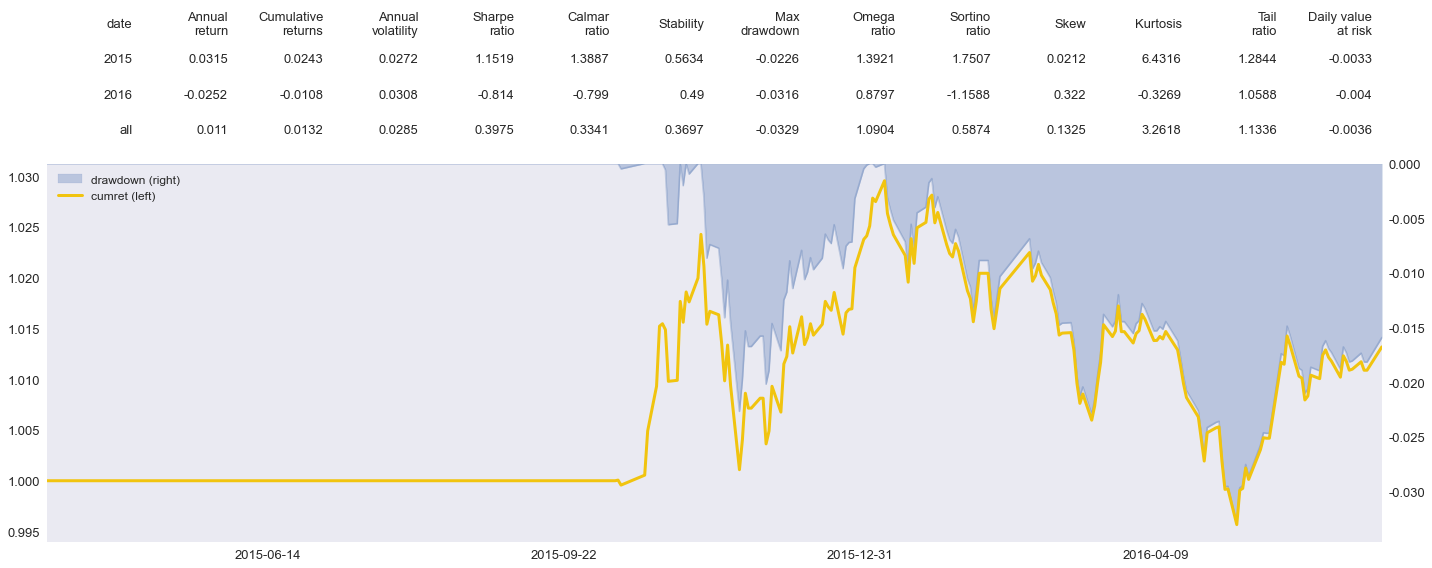

In [19]:
pnl = pd.Series(result[0].analyzers._TimeReturn.get_analysis()).dropna()
# 计算累计收益
cumulative = (pnl + 1).cumprod()
# 计算回撤序列
max_return = cumulative.cummax()
drawdown = (cumulative - max_return) / max_return
# 计算收益评价指标
import pyfolio as pf
# 按年统计收益指标
perf_stats_year = (pnl).groupby(pnl.index.to_period('y')).apply(lambda data: pf.timeseries.perf_stats(data)).unstack()
# 统计所有时间段的收益指标
perf_stats_all = pf.timeseries.perf_stats((pnl)).to_frame(name='all')
perf_stats = pd.concat([perf_stats_year, perf_stats_all.T], axis=0)
perf_stats_ = round(perf_stats,4).reset_index()


# 绘制图形
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import matplotlib.ticker as ticker # 导入设置坐标轴的模块
plt.style.use('seaborn') # plt.style.use('dark_background')

fig, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1.5, 4]}, figsize=(20,8))
cols_names = ['date', 'Annual\nreturn', 'Cumulative\nreturns', 'Annual\nvolatility',
       'Sharpe\nratio', 'Calmar\nratio', 'Stability', 'Max\ndrawdown',
       'Omega\nratio', 'Sortino\nratio', 'Skew', 'Kurtosis', 'Tail\nratio',
       'Daily value\nat risk']

# 绘制表格
ax0.set_axis_off() # 除去坐标轴
table = ax0.table(cellText = perf_stats_.values,
                bbox=(0,0,1,1), # 设置表格位置， (x0, y0, width, height)
                rowLoc = 'right', # 行标题居中
                cellLoc='right' ,
                colLabels = cols_names, # 设置列标题
                colLoc = 'right', # 列标题居中
                edges = 'open' # 不显示表格边框
                )
table.set_fontsize(13)

# 绘制累计收益曲线
ax2 = ax1.twinx()
ax1.yaxis.set_ticks_position('right') # 将回撤曲线的 y 轴移至右侧
ax2.yaxis.set_ticks_position('left') # 将累计收益曲线的 y 轴移至左侧
# 绘制回撤曲线
drawdown.plot.area(ax=ax1, label='drawdown (right)', rot=0, alpha=0.3, fontsize=13, grid=False)
# 绘制累计收益曲线
(cumulative).plot(ax=ax2, color='#F1C40F' , lw=3.0, label='cumret (left)', rot=0, fontsize=13, grid=False)
# 不然 x 轴留有空白
ax2.set_xbound(lower=cumulative.index.min(), upper=cumulative.index.max())
# 主轴定位器：每 5 个月显示一个日期：根据具体天数来做排版
ax2.xaxis.set_major_locator(ticker.MultipleLocator(100))
# 同时绘制双轴的图例
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2,l1+l2, fontsize=12, loc='upper left', ncol=1)

fig.tight_layout() # 规整排版
plt.show()